In [1]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.infer.util import log_likelihood
import jax
from jax import random
from jax import numpy as jnp
import numpy as np
from numpy.lib.recfunctions import drop_fields, append_fields
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

import bambi as bmb

In [2]:
numpyro.set_platform("cpu")

In [3]:
numpyro.set_host_device_count(8)

# Prepare data

In [10]:
data = pd.read_csv("../datasets/model_dataset.csv")

# Drop missing values
data = data.dropna(subset="industry")
data = data.dropna(subset="occup")
data = data.dropna(subset="exp")
data = data.dropna(subset="salary")

data = data.query("year == 1996")
dataset = data[['year','industry', 'occup', 'exp','salary',"sex",'elementary_edu','highschool_edu','postsec_edu','undergrad_edu','graduate_edu',
                'grad_highschool_refyear','grad_college_refyear','grad_univ_refyear','tenure','union','part_time',
                'public_sector','self_emp','age','firm_size','loc_size']].copy()

dataset.head(3)

,year,industry,occup,exp,salary,sex,elementary_edu,highschool_edu,postsec_edu,undergrad_edu,...,grad_college_refyear,grad_univ_refyear,tenure,union,part_time,public_sector,self_emp,age,firm_size,loc_size
14,1996,accommodation and food services,middle management,3.0,23647.752809,0,0,1,0,0,...,0,0,64.0,0,0,0,0,19.0,3,2
15,1996,manufacturing,natural and applied sciences,3.0,42040.449438,0,0,0,0,1,...,0,0,29.0,0,0,0,0,34.0,1,1
16,1996,health care and social assistance,clerical and supervisor occupations,13.0,21896.067416,1,0,1,0,0,...,0,0,7.0,0,1,0,0,33.0,4,1


# Dynamically update model

In [11]:
dataset = dataset[["year","industry","occup","postsec_edu","exp","salary"]]

In [12]:
class GammaGML():
    def __init__(self, name, parameters, target_var):
        self.name = name
        if not any(key in parameters for key in ["intercept", "slope"]):
            raise ValueError("parameters dictionary must contain keys 'intercept' and 'slope'")
        self.parameters = parameters
        self.target = target_var
        self.priors = {
            "normal": dist.Normal,
            "uniform": dist.Uniform,
            "beta": dist.Beta,
            "gamma": dist.Gamma,
            "poisson": dist.Poisson,
            "student_t": dist.StudentT,
            "halfnormal": dist.HalfNormal,
            "halfcauchy": dist.HalfCauchy}
        self.dims = {}
    
    def __repr__(self):
        vars = {key: [ var for var in value] for key, value in self.parameters.items()}
        return f"Model.{self.name} - params: {vars}"
    
    def standardize_var(self, variable):
        variable = (variable - variable.mean()) / variable.std()
        return variable
    
    def data_processing(self, dataset, standardize_vars=[], categorical_vars=[], year=None):
        self.dataset = dataset.to_records(index=False)

        if year is not None:
            if 'year' in self.dataset.dtype.names:
                self.dataset = self.dataset[self.dataset["year"] == year]
                self.dataset = drop_fields(self.dataset, "year")
            else:
                raise ValueError("year is not a column in the dataset")
            
        for var in standardize_vars:
            self.dataset[var] = self.standardize_var(self.dataset[var])

        for var in categorical_vars:
            self.dims[var], var_idx = np.unique(self.dataset[var], return_inverse=True)
            self.dataset = drop_fields(self.dataset, var)
            self.dataset = append_fields(self.dataset, var, var_idx, usemask=False)
    
    def hyperprior(self, var_type, var_name, var_params, prior_name):
        hyperpriors = {}
        if var_type == "error":
            scale_class = self.priors["halfnormal"]
            scale_prior = scale_class(**var_params["initial_values"])
            scale_shape = () if var_params["dims"] is None else tuple( self.dims[dim].shape[0] for dim in var_params["dims"] )
            scale = numpyro.sample(name = f"scale_{prior_name}", fn = scale_prior, sample_shape = scale_shape)
            hyperpriors["scale"] = scale
        
        elif var_type in ["intercept","slope"]:
            mu_class = self.priors["normal"]
            mu_prior = mu_class(**var_params["initial_values"])

            sigma_class = self.priors["halfnormal"]
            sigma_prior = sigma_class(scale=1)

            mu = numpyro.sample(name = f"mu_{prior_name}", fn = mu_prior)
            sigma = numpyro.sample(name = f"sigma_{prior_name}", fn = sigma_prior)
            hyperpriors["loc"] = mu
            hyperpriors["scale"] = sigma
        
        return hyperpriors

    def prior(self, var_type, var_name, var_params):
        if var_params["dims"] is not None:
            var_dim_names = f"[{', '.join(var_params['dims'])}]"
        else:
            var_dim_names = ""

        if var_type == "intercept":
            prior_name = f"avg_{self.target}{var_dim_names}"
        elif var_type == "slope":
            prior_name = f"beta_{var_name}{var_dim_names}"
        else:
            prior_name = f"{var_name}"

        if var_params["hyperprior"]:
            distribution_params = self.hyperprior(var_type, var_name, var_params, prior_name)
        else:
            distribution_params = var_params["initial_values"]        

        distribution_class = self.priors[var_params["prior"]]
        distribution = distribution_class(**distribution_params)
        sample_shape = () if var_params["dims"] is None else tuple( self.dims[dim].shape[0] for dim in var_params["dims"] )

        if var_params["parameterization"]=="centered":
            prior = numpyro.sample(name = prior_name, fn = distribution, sample_shape = sample_shape)
        elif var_params["parameterization"]=="non-centered":
            prior = numpyro.sample(name = prior_name,
                                   fn = dist.TransformedDistribution(dist.Normal(loc=0, scale=1),
                                                                     dist.transforms.AffineTransform(**distribution_params)),
                                   sample_shape = sample_shape)
        return prior
    
    def build(self, dataset, standardize_vars=[], categorical_vars=[], year=None):
        self.data_processing(dataset, standardize_vars, categorical_vars, year)

        variables = [ (element, var_name, params) for element, variable in self.parameters.items() for var_name, params in variable.items() ]

        def model():
            # Priors
            priors = []
            for var in variables:
                var_type, var_name, var_params = var
                priors.append((var_type, var_name, self.prior(var_type, var_name, var_params), var_params["dims"]))

            # Expected value
            mu = 0
            for prior in priors:
                var_type, var_name, var_prior, var_dims = prior
                
                if var_type == "shape":
                    shape = var_prior
                else:
                    if var_type == "slope":
                        var_data = self.dataset[var_name]
                    else:
                        var_data = 1

                    if var_dims is not None:
                        dims = tuple( self.dataset[dim] for dim in var_dims )
                        var_prior = var_prior[dims]

                    mu += var_prior * var_data
            
            mu = jnp.exp(mu)
            rate = shape / mu

            # Likelihood
            with numpyro.plate("data", size=self.dataset[self.target].shape[0]):
                numpyro.sample(self.target, dist.Gamma(concentration=shape, rate=rate), obs=self.dataset[self.target])
        return model


    def run_model(self, model, draws=4000, warmup=4000, chains=4, target_accept_prob=0.95, postprocess_fn=None, progress_bar=True):
        # Start from this source of randomness. We will split keys for subsequent operations.
        rng_key = random.PRNGKey(0)
        rng_key, rng_key_ = random.split(rng_key)

        # Run NUTS
        kernel = NUTS(model, target_accept_prob=target_accept_prob)
        mcmc = MCMC(kernel, num_warmup=warmup, num_samples=draws, num_chains=chains, chain_method='parallel', postprocess_fn=postprocess_fn, progress_bar=progress_bar)
        mcmc.run(rng_key)
        trace = az.from_numpyro(mcmc)
        return trace

In [16]:
params = {
    'intercept': {
        'avg_salary': {"prior": "normal", "initial_values": {"loc": 0, "scale": 1}, "dims": ["industry","occup"], "hyperprior": True, "parameterization": "non-centered"}
        },
    'slope': {
        'exp': {"prior": "normal", "initial_values": {"loc": 0, "scale": 1}, "dims": ["industry","occup"], "hyperprior": True, "parameterization": "non-centered"}
    },
    'shape': {
        'shape': {"prior": "uniform", "initial_values": {"low": 0, "high": 100}, "dims": None, "hyperprior": False, "parameterization": "centered"}
    }
}
gamma = GammaGML('test', parameters=params, target_var="salary")
gamma

Model.test - params: {'intercept': ['avg_salary'], 'slope': ['exp'], 'shape': ['shape']}

In [17]:
model = gamma.build(dataset, standardize_vars=["exp"], categorical_vars=["industry","occup","postsec_edu"])

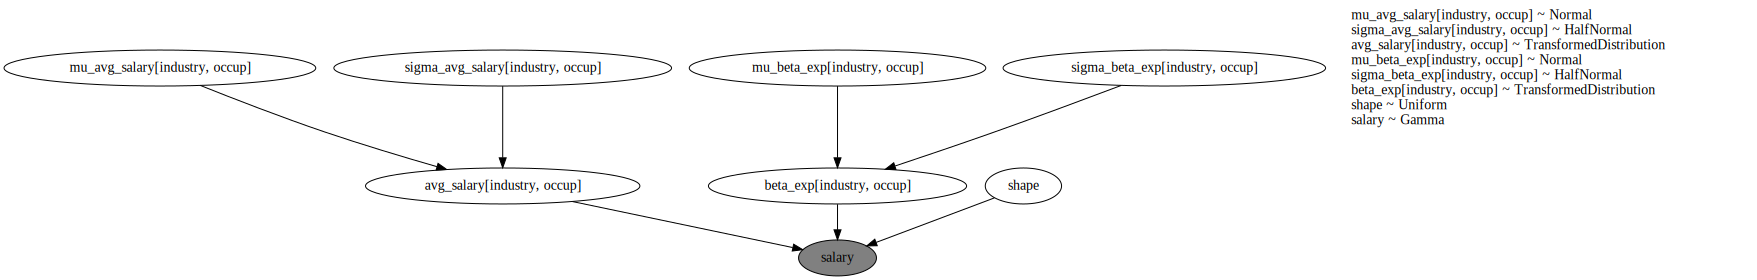

In [18]:
numpyro.render_model(model, render_distributions=True)

In [19]:
trace = gamma.run_model(model)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

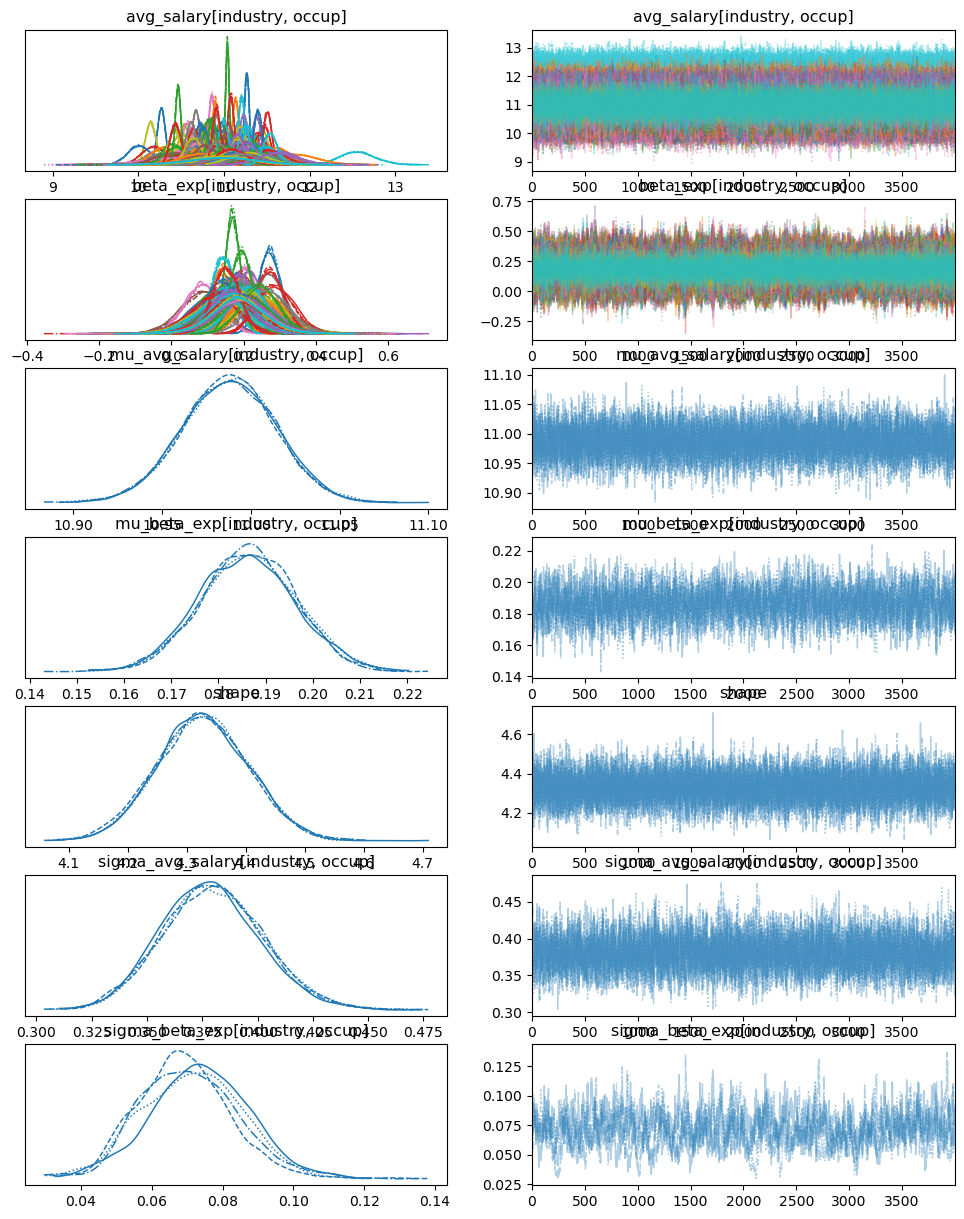

In [20]:
az.plot_trace(trace, figsize=(12, 15));

In [22]:
dataset.industry = dataset.industry.astype("category")
dataset.occup = dataset.occup.astype("category")

In [24]:
dataset.occup.cat.codes.values

array([8, 9, 2, ..., 7, 8, 7], dtype=int8)

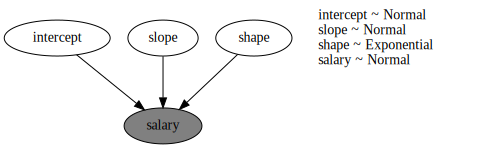

In [57]:
def test():
    intercept = numpyro.sample("intercept", dist.Normal(10, 1), sample_shape=(len(dataset.industry.unique()),))
    slope = numpyro.sample("slope", dist.Normal(0, 1), sample_shape=(len(dataset.industry.unique()),))

    mu = intercept[dataset.industry.cat.codes.values] + slope[dataset.industry.cat.codes.values] * dataset.exp.values

    sigma = numpyro.sample("shape", dist.Exponential(1))

    numpyro.sample("salary", dist.Normal(mu, sigma), obs=dataset.salary.values)

numpyro.render_model(test, render_distributions=True)

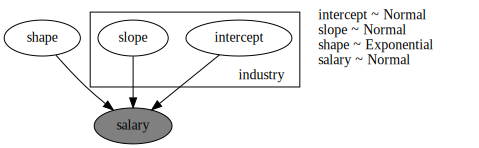

In [58]:
def test_plate():
    with numpyro.plate("industry", len(dataset.industry.unique())):
        intercept = numpyro.sample("intercept", dist.Normal(0, 1))
        slope = numpyro.sample("slope", dist.Normal(0, 1))

        mu = intercept[dataset.industry.cat.codes.values] + slope[dataset.industry.cat.codes.values] * dataset.exp.values

    sigma = numpyro.sample("shape", dist.Exponential(1))

    numpyro.sample("salary", dist.Normal(mu, sigma), obs=dataset.salary.values)

numpyro.render_model(test_plate, render_distributions=True)

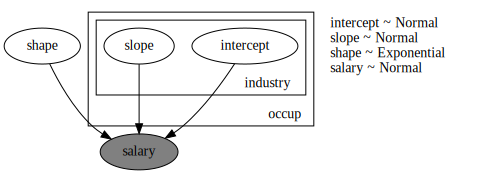

In [82]:
def test_nested_plate():
    with numpyro.plate("occup", len(dataset.occup.unique())):
        with numpyro.plate("industry", len(dataset.industry.unique())):
            intercept = numpyro.sample("intercept", dist.Normal(0, 1))
            slope = numpyro.sample("slope", dist.Normal(0, 1))

            mu = intercept[dataset.industry.cat.codes.values, dataset.occup.cat.codes.values] + slope[dataset.industry.cat.codes.values, dataset.occup.cat.codes.values] * dataset.exp.values

    sigma = numpyro.sample("shape", dist.Exponential(1))

    numpyro.sample("salary", dist.Normal(mu, sigma), obs=dataset.salary.values)

numpyro.render_model(test_nested_plate, render_distributions=True)

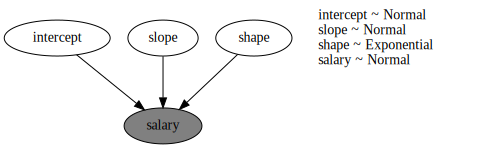

In [83]:
def test_nested():
    intercept = numpyro.sample("intercept", dist.Normal(0, 1), sample_shape=(len(dataset.industry.unique()), len(dataset.occup.unique())))
    slope = numpyro.sample("slope", dist.Normal(0, 1), sample_shape=(len(dataset.industry.unique()), len(dataset.occup.unique())))

    mu = intercept[dataset.industry.cat.codes.values, dataset.occup.cat.codes.values] + slope[dataset.industry.cat.codes.values, dataset.occup.cat.codes.values] * dataset.exp.values

    sigma = numpyro.sample("shape", dist.Exponential(1))

    numpyro.sample("salary", dist.Normal(mu, sigma), obs=dataset.salary.values)

numpyro.render_model(test_nested, render_distributions=True)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

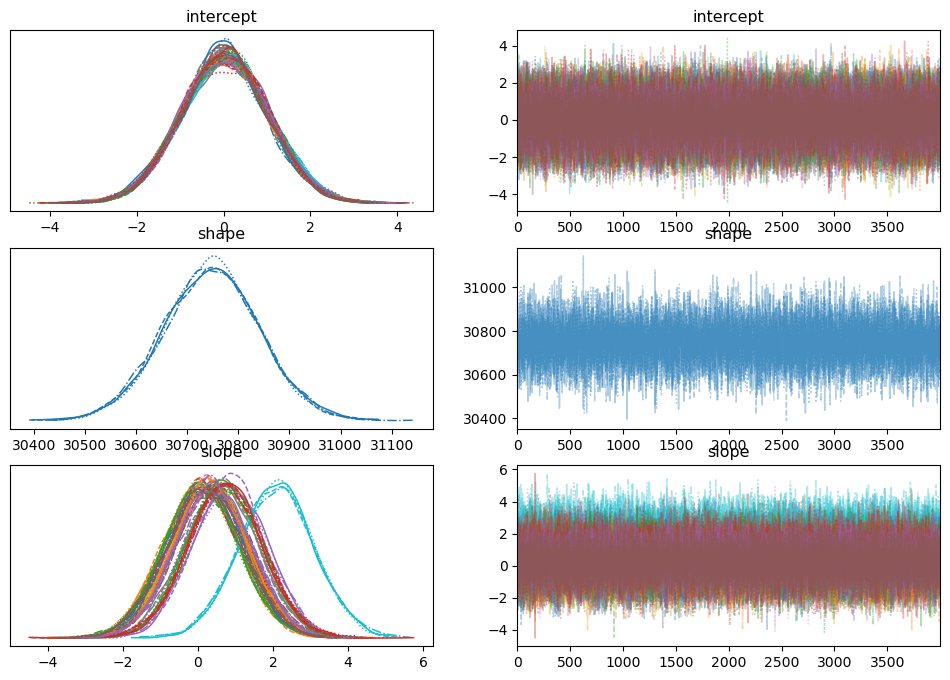

In [60]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=4000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)
trace_plate = az.from_numpyro(mcmc)
az.plot_trace(trace, figsize=(12, 8));

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

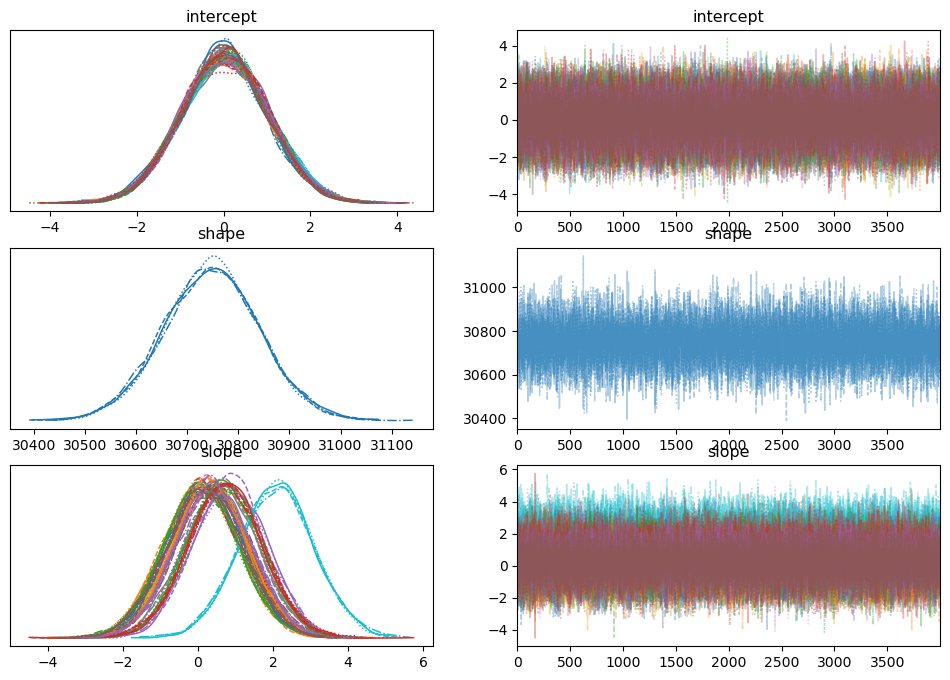

In [61]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test_plate, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=4000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)
trace_plate = az.from_numpyro(mcmc)
az.plot_trace(trace_plate, figsize=(12, 8));

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

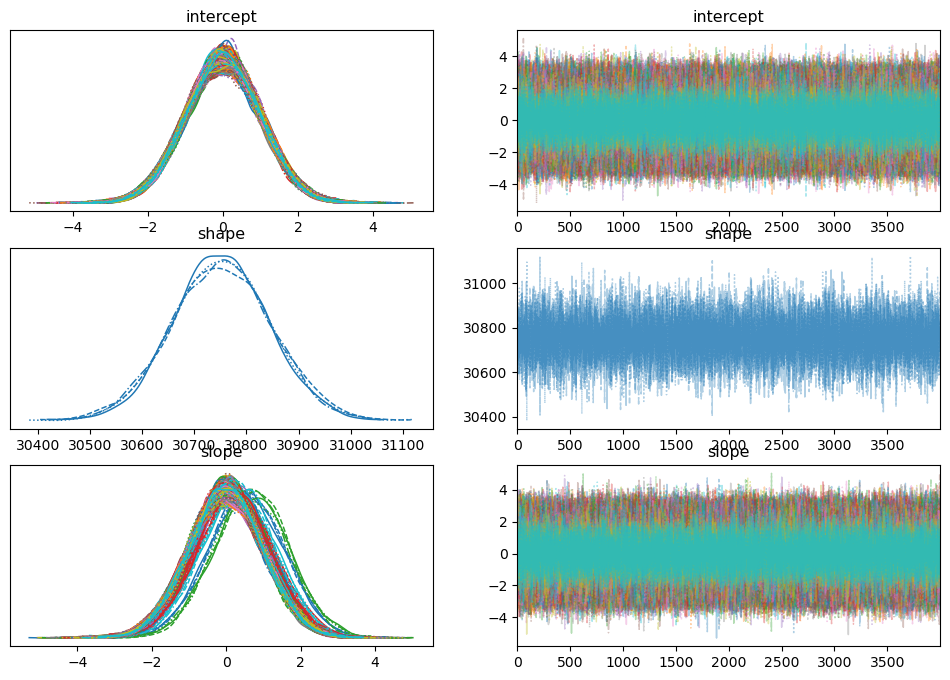

In [84]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test_nested_plate, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=4000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)
trace_nested_plate = az.from_numpyro(mcmc)
az.plot_trace(trace_nested_plate, figsize=(12, 8));

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

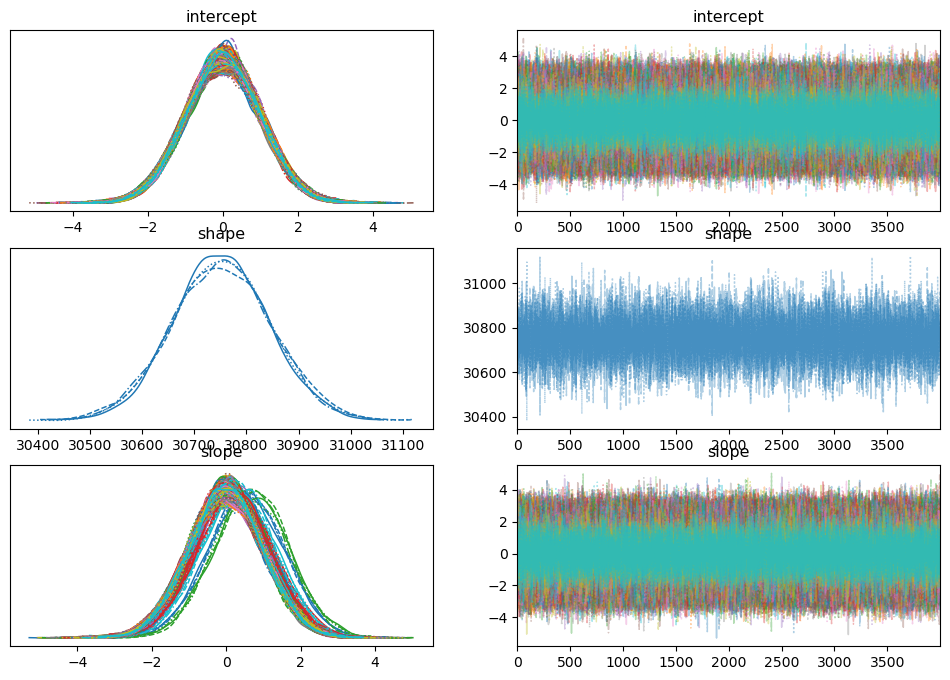

In [85]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test_nested, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=4000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)
trace_nested = az.from_numpyro(mcmc)
az.plot_trace(trace_nested, figsize=(12, 8));

In [86]:
az.summary(trace_nested_plate).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"intercept[0, 0]",0.012,0.988,-1.805,1.936,0.005,0.009,44827.0,11117.0,1.0
"intercept[0, 1]",-0.001,1.006,-1.893,1.852,0.005,0.010,40616.0,10659.0,1.0
"intercept[0, 2]",0.010,1.013,-1.853,1.952,0.005,0.010,42472.0,10600.0,1.0
"intercept[0, 3]",-0.001,1.004,-1.922,1.835,0.005,0.010,42412.0,11069.0,1.0
"intercept[0, 4]",0.004,0.987,-1.827,1.857,0.005,0.010,39464.0,10357.0,1.0
"intercept[0, 5]",-0.005,1.001,-1.854,1.914,0.005,0.010,41871.0,10820.0,1.0
"intercept[0, 6]",-0.007,1.000,-1.926,1.844,0.005,0.010,41179.0,11035.0,1.0
"intercept[0, 7]",-0.007,0.991,-1.835,1.897,0.005,0.009,37735.0,10888.0,1.0
"intercept[0, 8]",0.013,1.003,-1.888,1.846,0.005,0.010,40485.0,10114.0,1.0
"intercept[0, 9]",0.002,1.003,-1.849,1.907,0.005,0.010,46605.0,11088.0,1.0


In [87]:
az.summary(trace_nested).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"intercept[0, 0]",0.012,0.988,-1.805,1.936,0.005,0.009,44827.0,11117.0,1.0
"intercept[0, 1]",-0.001,1.006,-1.893,1.852,0.005,0.010,40616.0,10659.0,1.0
"intercept[0, 2]",0.010,1.013,-1.853,1.952,0.005,0.010,42472.0,10600.0,1.0
"intercept[0, 3]",-0.001,1.004,-1.922,1.835,0.005,0.010,42412.0,11069.0,1.0
"intercept[0, 4]",0.004,0.987,-1.827,1.857,0.005,0.010,39464.0,10357.0,1.0
"intercept[0, 5]",-0.005,1.001,-1.854,1.914,0.005,0.010,41871.0,10820.0,1.0
"intercept[0, 6]",-0.007,1.000,-1.926,1.844,0.005,0.010,41179.0,11035.0,1.0
"intercept[0, 7]",-0.007,0.991,-1.835,1.897,0.005,0.009,37735.0,10888.0,1.0
"intercept[0, 8]",0.013,1.003,-1.888,1.846,0.005,0.010,40485.0,10114.0,1.0
"intercept[0, 9]",0.002,1.003,-1.849,1.907,0.005,0.010,46605.0,11088.0,1.0


In [134]:
def model(industry, occupation, experience, salary):
    # Assuming industry and occupation are integer indices
    num_industries = len(set(industry))
    num_occupations = len(set(occupation))
    
    # Priors for the intercept and slope parameters, 
    # with a dimension for each industry and occupation
    with numpyro.plate('industry_occupation_plate', num_industries * num_occupations):
        intercept = numpyro.sample('intercept', dist.Normal(0, 1))
        slope = numpyro.sample('slope', dist.Normal(0, 1))
    
    # Prior for the standard deviation of the residuals
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    
    # Creating an index that represents each combination of industry and occupation
    industry_occupation_index = industry * num_occupations + occupation
    
    # Expected value according to the linear regression model
    mu = intercept[industry_occupation_index] + slope[industry_occupation_index] * experience
    
    # Likelihood of the observed data
    with numpyro.plate('data', len(experience)):
        numpyro.sample('obs', dist.Normal(mu, sigma), obs=salary)


In [135]:
numpyro.render_model(model(dataset.industry.values, dataset.postsec_edu.values, dataset.exp.values, dataset.salary.values), render_distributions=True)

AssertionError: 

In [43]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [261]:
a.data_processing(dataset, standardize_vars=["exp"], categorical_vars=["industry"])

In [262]:
a.dataset[a.target]

array([164249.34152766,  46537.31343284,  17109.30640913, ...,
        43747.44897959,  25850.76530612,  13256.80272109])

In [263]:
a.run_model("test", a.dataset, a.target)

intercept {'exp': {'prior': 'normal', 'initial_values': {'loc': 0, 'scale': 1}, 'dims': None}}
slope {'age': {'prior': 'normal', 'initial_values': {'loc': 0, 'scale': 1}, 'dims': None}}
error {'sigma': {'prior': 'halfnormal', 'initial_values': {'scale': 1}, 'dims': None}}


NameError: name 'exp' is not defined

In [235]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(a.build())
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)

intercept {'exp': {'prior': 'normal', 'initial_values': {'mu': 0, 'sigma': 1}, 'dims': None}}
['loc', 'scale']


TypeError: Normal.__init__() got an unexpected keyword argument 'reparametrized_params'

In [61]:
a.prior("intercept", "edu", params["intercept"]["edu"])

AssertionError: 

In [48]:
a.data_processing(dataset, year=2011, standardize_vars=["exp"], categorical_vars=["industry","postsec_edu"])

NameError: name 'dataset' is not defined

In [10]:
b.reparametrized_params

[10, 'scale']

In [9]:
b.reparametrized_params[0] = 10

In [367]:
dataset.query("year == 2011")

,year,industry,postsec_edu,exp,salary
917,2011,public administration,1,31.0,87547.836938
918,2011,transportation and warehousing,1,21.0,100517.886855
919,2011,health care and social assistance,1,23.0,59662.229617
924,2011,health care and social assistance,1,18.0,55771.214642
925,2011,manufacturing,0,20.0,103760.399334
...,...,...,...,...,...
87013,2011,construction,0,4.0,81062.811980
87014,2011,health care and social assistance,0,8.0,74577.787022
87015,2011,construction,1,27.0,214005.823627
87016,2011,trade,1,2.0,11997.296173


In [82]:
np.unique(a.dataset.year)

array([2011])

In [24]:
def postprocess_samples(samples):
    return {k: jnp.exp(v) for k, v in samples.items()}

In [25]:
def create_model_arrays(dataset: pd.DataFrame, standardize_vars: list=[]):
    model_array = {}
    for col_name, col_data in dataset.select_dtypes(include=["object"]).items():
        model_array[col_name] = {}
        model_array[col_name]["data"] = jnp.array(pd.factorize(col_data)[0])
        model_array[col_name]["cats"] = list(pd.factorize(col_data)[1])
    
    for col_name, col_data in dataset.select_dtypes(include=["int64", "float64"]).items():
        model_array[col_name] = {}
        if col_name in standardize_vars:
            model_array[col_name]["data"] = jnp.array((col_data - col_data.mean()) / col_data.std())
            model_array[col_name]["cats"] = None
        else:
            model_array[col_name]["data"] = jnp.array(col_data)
            model_array[col_name]["cats"] = None
    
    return model_array   

In [101]:
def build_model(model_name, dataset, dependent_var):
    model_array = create_model_arrays(dataset, standardize_vars=["exp", "age", "tenure"])
    
    # Priors
    shape = numpyro.sample("shape", dist.Exponential(1))
    avg_salary_ind = numpyro.sample("avg_salary_ind", dist.Normal(10, 1), sample_shape=(len(model_array["industry"]["cats"]),))
    # avg_salary_occ = numpyro.sample("avg_salary_occ", dist.Normal(10, 1), sample_shape=(len(model_array["occup"]["cats"]),))

    print(avg_salary_ind)

    slopes = []
    data = []
    for col_name, col_data in model_array.items():
        if col_name not in ["industry", "occup", dependent_var]:
            if "_edu" in col_name:
                slopes.append(numpyro.sample(f"beta_{col_name}", dist.HalfNormal(1)))
            else:
                slopes.append(numpyro.sample(f"beta_{col_name}", dist.Normal(0, 1)))
                
            data.append(col_data["data"])

    slopes = jnp.array(slopes)
    data = jnp.array(data)

    # Expected value (mu)
    # mu = avg_salary_ind[model_array["industry"]["data"]] + avg_salary_occ[model_array["occup"]["data"]] + jnp.dot(slopes, data)
    mu = avg_salary_ind[model_array["industry"]["data"]] + jnp.dot(slopes, data)
    mu = jnp.exp(mu)
    print(mu)
    rate = shape / mu

    # Likelihood
    numpyro.sample(dependent_var, dist.Gamma(concentration=shape, rate=rate), obs=model_array[dependent_var]["data"])

In [102]:
def postprocess_trace(trace):
    trace = trace.copy()
    for var_name, var_data in trace.posterior.data_vars.items():
        if var_name in ["avg_salary_ind", "avg_salary_occ"]:
            trace.posterior[var_name].values[:] = np.exp(var_data)
        elif var_name not in ["shape"]:
            # Get relative values (%)
            trace.posterior[var_name].values[:] = np.exp(var_data) - 1
            # # Get absolute values ($)
            # trace.posterior[var_name].values[:] = (np.exp(var_data) - 1) * (trace.posterior["avg_salary_ind"][:, :] * trace.posterior["avg_salary_occ"][:, :]) 
    return trace

In [103]:
def run_model(model_name, dataset, dependent_var, draws=2000, warmup=2000, chains=4, target_accept_prob=0.95, postprocess_fn=None):
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS
    kernel = NUTS(build_model, target_accept_prob=target_accept_prob)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=draws, num_chains=chains, chain_method='parallel', postprocess_fn=postprocess_fn, progress_bar=True)
    mcmc.run(rng_key, model_name, dataset, dependent_var)
    trace = az.from_numpyro(mcmc)
    updated_trace = postprocess_trace(trace)
    updated_trace.to_netcdf(f"traces/{model_name}.nc")
    return trace

In [104]:
# parameters = ["exp","sex",{"edu_level":['elementary_edu','highschool_edu','postsec_edu','undergrad_edu','graduate_edu']},
#     {"grad_refyear":['grad_highschool_refyear','grad_college_refyear','grad_univ_refyear']},'tenure','union','part_time',
#     'public_sector','self_emp',{"firm_size":['firm_size','loc_size']},'age']

parameters = ["exp",'age']

columns = ['salary','industry']
for id_run, param in enumerate(parameters):
    # Append param to columns
    if isinstance(param, dict):
        columns += list(param.values())[0]
    else:
        columns.append(param)

    if id_run == 0:
        model_name = f"M{id_run}-{param}"
    elif isinstance(param, dict):
        model_name = f"M{id_run}-M{id_run-1}+{list(param.keys())[0]}"
    else:
        model_name = f"M{id_run}-M{id_run-1}+{param}"

    trace = run_model(model_name=model_name, dataset=dataset[columns], dependent_var="salary", draws=2000, warmup=2000, chains=4)
                                # target_accept_prob=0.95, postprocess_fn=None)
    print(f"Run {id_run} completed") 

NameError: name 'create_model_arrays' is not defined

In [34]:
trace

NameError: name 'trace' is not defined

In [ ]:
def postprocess_samples(samples):
    return {k: jnp.exp(v) for k, v in samples.items()}
def create_model_arrays(dataset: pd.DataFrame, standardize_vars: list=[]):
    model_array = {}
    for col_name, col_data in dataset.select_dtypes(include=["object"]).items():
        model_array[col_name] = {}
        model_array[col_name]["data"] = jnp.array(pd.factorize(col_data)[0])
        model_array[col_name]["cats"] = list(pd.factorize(col_data)[1])
    
    for col_name, col_data in dataset.select_dtypes(include=["int64", "float64"]).items():
        model_array[col_name] = {}
        if col_name in standardize_vars:
            model_array[col_name]["data"] = jnp.array((col_data - col_data.mean()) / col_data.std())
            model_array[col_name]["cats"] = None
        else:
            model_array[col_name]["data"] = jnp.array(col_data)
            model_array[col_name]["cats"] = None
    
    return model_array   
def build_model(model_name, dataset, dependent_var):
    model_array = create_model_arrays(dataset, standardize_vars=["exp", "age", "tenure"])
    
    # Priors
    shape = numpyro.sample("shape", dist.Exponential(1))
    avg_salary_ind = numpyro.sample("avg_salary_ind", dist.Normal(10, 1), sample_shape=(len(model_array["industry"]["cats"]),))
    avg_salary_occ = numpyro.sample("avg_salary_occ", dist.Normal(10, 1), sample_shape=(len(model_array["occup"]["cats"]),))

    slopes = []
    data = []
    for col_name, col_data in model_array.items():
        if col_name not in ["industry", "occup", dependent_var]:
            if "_edu" in col_name:
                slopes.append(numpyro.sample(f"beta_{col_name}", dist.HalfNormal(1)))
            else:
                slopes.append(numpyro.sample(f"beta_{col_name}", dist.Normal(0, 1)))
                
            data.append(col_data["data"])

    slopes = jnp.array(slopes)
    data = jnp.array(data)

    # Expected value (mu)
    mu = avg_salary_ind[model_array["industry"]["data"]] + avg_salary_occ[model_array["occup"]["data"]] + jnp.dot(slopes, data)
    mu = jnp.exp(mu)
    rate = shape / mu

    # Likelihood
    numpyro.sample(dependent_var, dist.Gamma(concentration=shape, rate=rate), obs=model_array[dependent_var]["data"])
def postprocess_trace(trace):
    trace = trace.copy()
    for var_name, var_data in trace.posterior.data_vars.items():
        if var_name in ["avg_salary_ind", "avg_salary_occ"]:
            trace.posterior[var_name].values[:] = np.exp(var_data)
        elif var_name not in ["shape"]:
            # Get relative values (%)
            trace.posterior[var_name].values[:] = np.exp(var_data) - 1
            # # Get absolute values ($)
            # trace.posterior[var_name].values[:] = (np.exp(var_data) - 1) * (trace.posterior["avg_salary_ind"][:, :] * trace.posterior["avg_salary_occ"][:, :]) 
    return trace
def run_model(model_name, dataset, dependent_var, draws=2000, warmup=2000, chains=4, target_accept_prob=0.95, postprocess_fn=None):
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS
    kernel = NUTS(build_model, target_accept_prob=target_accept_prob)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=draws, num_chains=chains, chain_method='parallel', postprocess_fn=postprocess_fn, progress_bar=False)
    mcmc.run(rng_key, model_name, dataset, dependent_var)
    trace = az.from_numpyro(mcmc)
    updated_trace = postprocess_trace(trace)
    updated_trace.to_netcdf(f"traces/{model_name}.nc")
    return trace

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

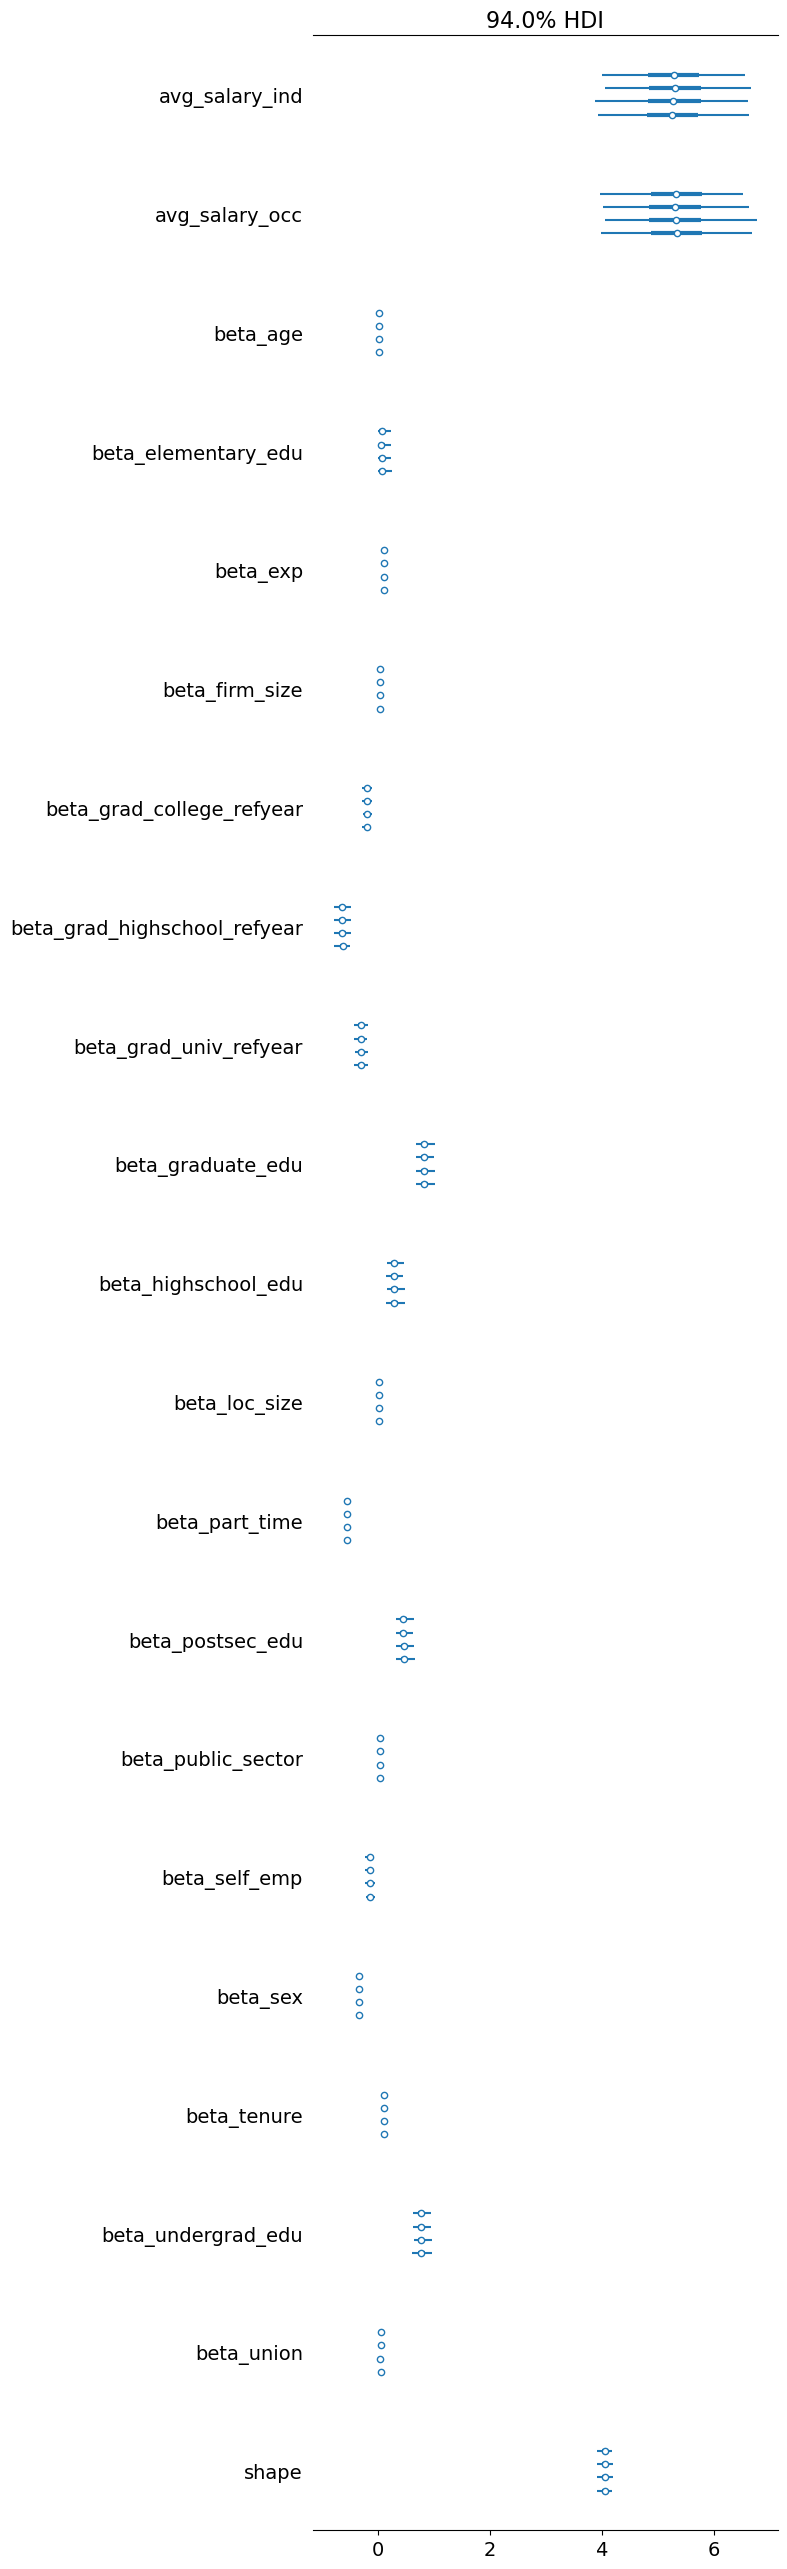

In [45]:
az.plot_forest(trace)

#TODO:
1. Run backward elimination (adding the log calculation) using a for loop
2. Plotting the famous chart to see if adding variables is relevant
3. Run the model with the variables selected but updating the priors

In [281]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
avg_salary_ind,5.276,0.698,3.930,6.585,0.010,0.007,4946.0,5164.0,1.0
avg_salary_occ,5.312,0.697,3.980,6.622,0.010,0.007,4853.0,5214.0,1.0
beta_age,0.020,0.013,-0.002,0.045,0.000,0.000,5710.0,5474.0,1.0
beta_elementary_edu,0.092,0.080,0.000,0.242,0.002,0.001,2185.0,3213.0,1.0
beta_exp,0.110,0.013,0.085,0.133,0.000,0.000,5677.0,5464.0,1.0
beta_firm_size,0.041,0.006,0.031,0.052,0.000,0.000,9246.0,5939.0,1.0
beta_grad_college_refyear,-0.192,0.045,-0.272,-0.102,0.000,0.000,9857.0,6221.0,1.0
beta_grad_highschool_refyear,-0.627,0.078,-0.781,-0.485,0.001,0.001,9460.0,6047.0,1.0
beta_grad_univ_refyear,-0.299,0.066,-0.421,-0.177,0.001,0.001,8599.0,6062.0,1.0
beta_graduate_edu,0.837,0.092,0.680,1.014,0.002,0.001,2278.0,3264.0,1.0


# Test model

In [15]:
data.shape

(5475, 47)

In [7]:
ind_idx, ind_cats = pd.factorize(data["industry"])
occup_idx, occup_cats = pd.factorize(data["occup"])
exp_idx = jnp.array(data["exp"].values)

elementary_edu_idx = jnp.array(data["elementary_edu"].values)
highschool_edu_idx = jnp.array(data["highschool_edu"].values)
postsec_edu_idx = jnp.array(data["postsec_edu"].values)
undergrad_edu_idx = jnp.array(data["undergrad_edu"].values)
graduate_edu_idx = jnp.array(data["graduate_edu"].values)

grad_highschool_refyear_idx = jnp.array(data["grad_highschool_refyear"].values)
grad_college_refyear_idx = jnp.array(data["grad_college_refyear"].values)
grad_univ_refyear_idx = jnp.array(data["grad_univ_refyear"].values)

public_sector_idx = jnp.array(data["public_sector"].values)
self_emp_idx = jnp.array(data["self_emp"].values)
union_idx = jnp.array(data["union"].values)
part_time_idx = jnp.array(data["part_time"].values)

tenure_idx = jnp.array(data["tenure"].values)
age_idx = jnp.array(data["age"].values)
firm_size_idx = jnp.array(data["firm_size"].values)
loc_size_idx = jnp.array(data["loc_size"].values)
sex_idx = jnp.array(data["sex"].values)

salary_idx = jnp.array(data["salary"].values)

In [269]:
exp_idx = (exp_idx - exp_idx.mean()) / exp_idx.std()
age_idx = (age_idx - age_idx.mean()) / age_idx.std()
tenure_idx = (tenure_idx - tenure_idx.mean()) / tenure_idx.std()

In [270]:
def model():
    intercept = numpyro.sample("intercept", dist.Normal(10, 1))#, sample_shape=(len(ind_cats),))
    occup = numpyro.sample("occup", dist.Normal(10, 1))#, sample_shape=(len(occup_cats),))
    exp = numpyro.sample("exp", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    elementary_edu = numpyro.sample("elementary_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))
    highschool_edu = numpyro.sample("highschool_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))
    postsec_edu = numpyro.sample("postsec_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))
    undergrad_edu = numpyro.sample("undergrad_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))
    graduate_edu = numpyro.sample("graduate_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))

    grad_highschool_refyear = numpyro.sample("grad_highschool_refyear", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    grad_college_refyear = numpyro.sample("grad_college_refyear", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    grad_univ_refyear = numpyro.sample("grad_univ_refyear", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))

    public_sector = numpyro.sample("public_sector", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    self_emp = numpyro.sample("self_emp", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    union = numpyro.sample("union", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    part_time = numpyro.sample("part_time", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))

    tenure = numpyro.sample("tenure", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    age = numpyro.sample("age", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    firm_size = numpyro.sample("firm_size", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    loc_size = numpyro.sample("loc_size", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    sex = numpyro.sample("sex", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))

    shape = numpyro.sample("shape", dist.Exponential(1))

    mu = jnp.exp(intercept + occup + exp * exp_idx + elementary_edu * elementary_edu_idx + 
                    highschool_edu * highschool_edu_idx + postsec_edu * postsec_edu_idx + 
                    undergrad_edu * undergrad_edu_idx + graduate_edu * graduate_edu_idx +
                    grad_highschool_refyear * grad_highschool_refyear_idx + grad_college_refyear * grad_college_refyear_idx +
                    grad_univ_refyear * grad_univ_refyear_idx + public_sector * public_sector_idx +
                    self_emp * self_emp_idx + union * union_idx + part_time * part_time_idx +
                    tenure * tenure_idx + age * age_idx + firm_size * firm_size_idx +
                    loc_size * loc_size_idx + sex * sex_idx)
                    
    rate = shape / mu

    numpyro.sample("salary", dist.Gamma(concentration=shape, rate=rate), obs=salary_idx)

In [271]:
def postprocess_samples(samples):
    return {k: jnp.exp(v) for k, v in samples.items()}

In [272]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model, target_accept_prob=0.95)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=2000, num_samples=num_samples, num_chains=4, chain_method='parallel', postprocess_fn=None)
mcmc.run(rng_key)
# mcmc.print_summary()
# samples = mcmc.get_samples()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [273]:
az.summary(az.from_numpyro(mcmc))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
age,0.020,0.013,-0.004,0.044,0.000,0.000,5129.0,5060.0,1.0
elementary_edu,0.098,0.084,0.000,0.251,0.002,0.001,1768.0,3056.0,1.0
exp,0.109,0.013,0.084,0.133,0.000,0.000,5226.0,5019.0,1.0
firm_size,0.041,0.006,0.030,0.052,0.000,0.000,9431.0,5475.0,1.0
grad_college_refyear,-0.192,0.045,-0.277,-0.107,0.000,0.000,8817.0,5558.0,1.0
grad_highschool_refyear,-0.628,0.079,-0.776,-0.480,0.001,0.001,8294.0,5747.0,1.0
grad_univ_refyear,-0.298,0.066,-0.422,-0.176,0.001,0.000,8724.0,5706.0,1.0
graduate_edu,0.843,0.095,0.685,1.031,0.002,0.002,1860.0,3137.0,1.0
highschool_edu,0.310,0.092,0.150,0.486,0.002,0.002,1804.0,3026.0,1.0
intercept,5.312,0.694,3.990,6.591,0.010,0.007,4440.0,5319.0,1.0


In [ ]:
az.plot_trace(az.from_numpyro(mcmc), var_names=["intercept","occup","exp","elementary_edu","highschool_edu","postsec_edu",
                                                "undergrad_edu","graduate_edu","shape"],combined=True, figsize=(12, 25));

In [171]:
az.plot_trace(trace, var_names=["avg_salary_ind","avg_salary_occ","beta_exp","beta_elementary_edu","beta_highschool_edu",
                                "beta_postsec_edu","beta_undergrad_edu","beta_graduate_edu","beta_grad_highschool_refyear",
                                "beta_grad_college_refyear","beta_grad_univ_refyear","beta_public_sector","beta_self_emp",
                                "beta_union","beta_part_time","beta_tenure","beta_age","beta_firm_size","beta_loc_size",
                                "beta_sex","shape"],combined=True, figsize=(12, 25));

KeyError: 'var names: "[\'beta_elementary_edu\' \'beta_highschool_edu\' \'beta_postsec_edu\'\\n \'beta_undergrad_edu\' \'beta_graduate_edu\' \'beta_grad_highschool_refyear\'\\n \'beta_grad_college_refyear\' \'beta_grad_univ_refyear\' \'beta_public_sector\'\\n \'beta_self_emp\' \'beta_union\' \'beta_part_time\' \'beta_tenure\' \'beta_age\'\\n \'beta_firm_size\' \'beta_loc_size\' \'beta_sex\'] are not present" in dataset'